In [2]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud

In [4]:
# Load data
news = pd.read_csv('../Data/raw_analyst_ratings.csv')

In [5]:
# Before dropping, check if the column exists
if 'Unnamed: 0' in news.columns:
    print("Column 'Unnamed: 0' found. Dropping it...")
    before_cols = news.shape[1]
    news = news.drop(columns=['Unnamed: 0'])
    after_cols = news.shape[1]
    print(f"Dropped 1 column: 'Unnamed: 0'")
    print(f"Columns before: {before_cols}, Columns after: {after_cols}")
else:
    print("Column 'Unnamed: 0' not found. No column dropped.")


Column 'Unnamed: 0' found. Dropping it...
Dropped 1 column: 'Unnamed: 0'
Columns before: 6, Columns after: 5


In [10]:
news.head()

,headline,url,publisher,date,stock,publisher_count,headline_length
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A,4371,39
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A,4371,42
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A,186979,29
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A,186979,44
4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A,24826,87


Headline Length Statistics:
count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


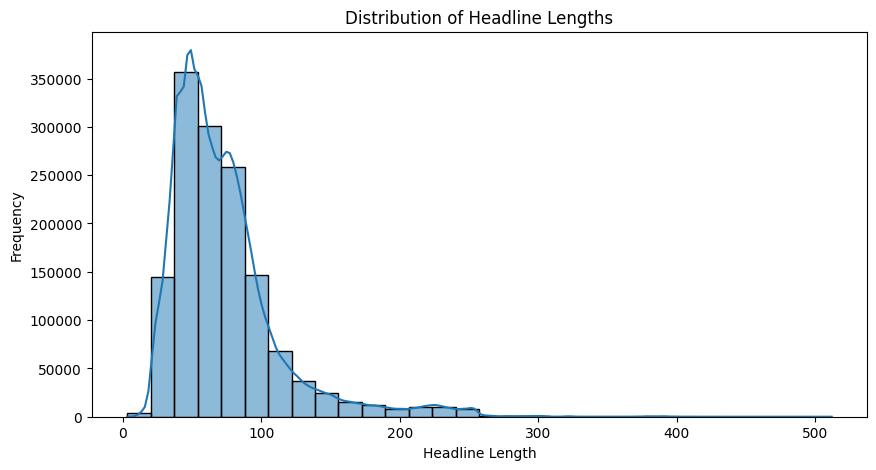

In [9]:
# ==========================
# Descriptive Statistics
# ==========================

# Headline length
news['headline'] = news['headline'].fillna('')
news['headline_length'] = news['headline'].apply(len)

# Show basic stats
print("Headline Length Statistics:")
print(news['headline_length'].describe())

# Plot headline length distribution
plt.figure(figsize=(10, 5))
sns.histplot(news['headline_length'], bins=30, kde=True)
plt.title('Distribution of Headline Lengths')
plt.xlabel('Headline Length')
plt.ylabel('Frequency')
plt.show()

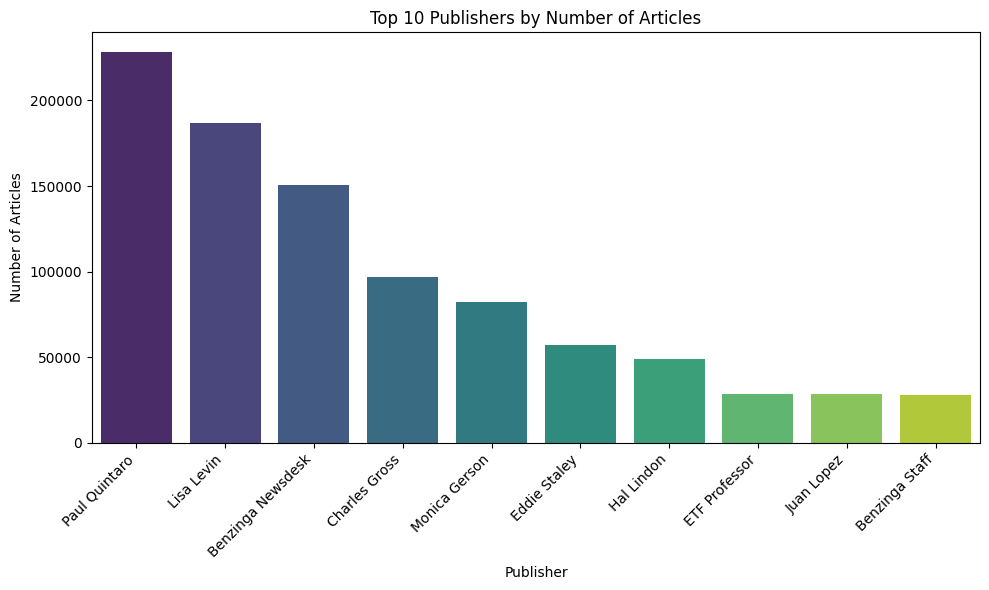

Top Email Domains (if present):
domain
benzinga.com              7937
gmail.com                  139
andyswan.com                 5
investdiva.com               2
tothetick.com                2
eosdetroit.io                1
forextraininggroup.com       1
stockmetrix.net              1
Name: count, dtype: int64


In [11]:
# ==========================
# Publisher Analysis
# ==========================

# Count articles per publisher
publisher_counts = news.groupby('publisher').size().reset_index(name='publisher_count')
news = news.merge(publisher_counts, on='publisher', how='left')

# Top 10 publishers bar plot
top_publishers = publisher_counts.nlargest(10, 'publisher_count')

plt.figure(figsize=(10, 6))
sns.barplot(x='publisher', y='publisher_count', data=top_publishers, palette='viridis')
plt.title('Top 10 Publishers by Number of Articles')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Extract domain if email format
news['domain'] = news['publisher'].str.extract(r'@([\w\.-]+)')
domain_counts = news['domain'].value_counts().head(10)
print("Top Email Domains (if present):")
print(domain_counts)

In [12]:
# ==========================
# Date & Time Processing
# ==========================

# Convert to datetime
news['date'] = pd.to_datetime(news['date'], errors='coerce')

# Extract date parts
news['year'] = news['date'].dt.year
news['month'] = news['date'].dt.month
news['day'] = news['date'].dt.day
news['day_of_week'] = news['date'].dt.day_name()
news['hour'] = news['date'].dt.hour

# Missing values?
print("Missing values summary:")
print(news.isnull().sum())

Missing values summary:
headline                   0
url                        0
publisher                  0
date                 1351341
stock                      0
publisher_count_x          0
headline_length            0
publisher_count_y          0
domain               1399240
year                 1351341
month                1351341
day                  1351341
day_of_week          1351341
hour                 1351341
dtype: int64


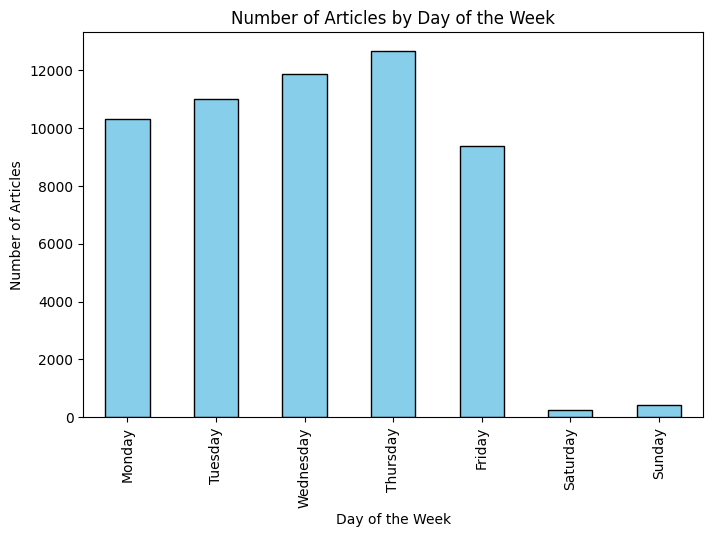

In [13]:
# ==========================
# Articles by Day of Week
# ==========================

day_counts = news['day_of_week'].value_counts()
day_counts = day_counts.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(8, 5))
day_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Articles by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Articles')
plt.show()


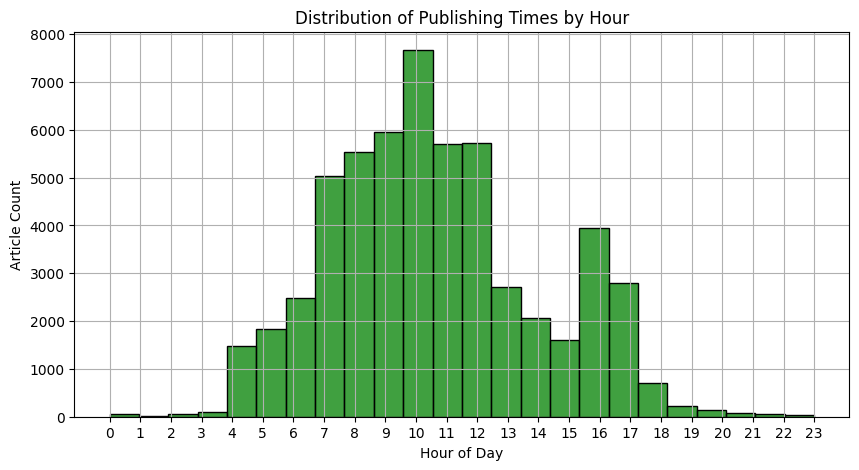

In [14]:
# ==========================
# Publishing Hour Distribution
# ==========================

plt.figure(figsize=(10, 5))
sns.histplot(news['hour'].dropna(), bins=24, kde=False, color='green')
plt.title('Distribution of Publishing Times by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Article Count')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

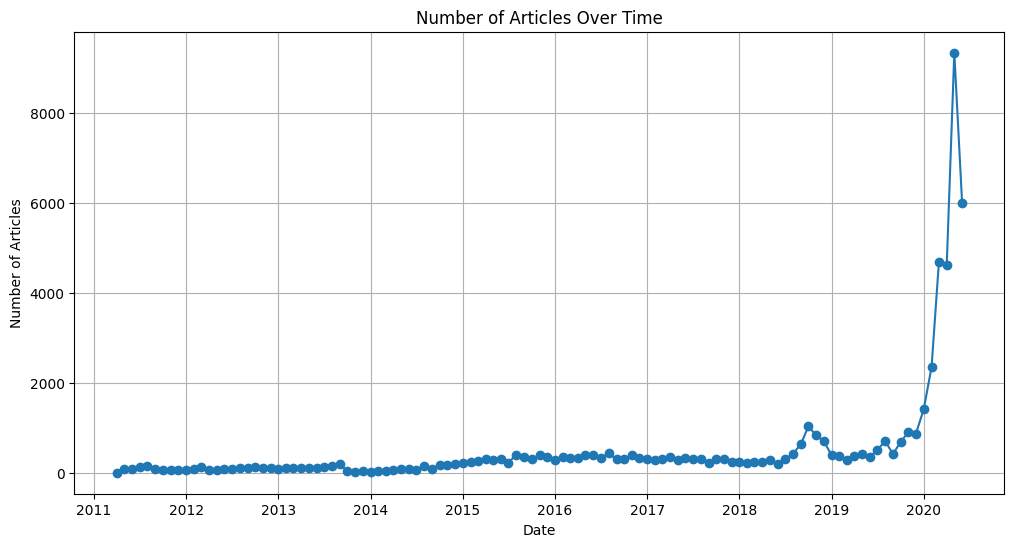

In [15]:
# ==========================
# Time Series Analysis
# ==========================

monthly_counts = news.groupby(['year', 'month']).size().reset_index(name='article_count')
monthly_counts['date'] = pd.to_datetime(monthly_counts[['year', 'month']].assign(day=1))

plt.figure(figsize=(12, 6))
plt.plot(monthly_counts['date'], monthly_counts['article_count'], marker='o', linestyle='-')
plt.title('Number of Articles Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.show()

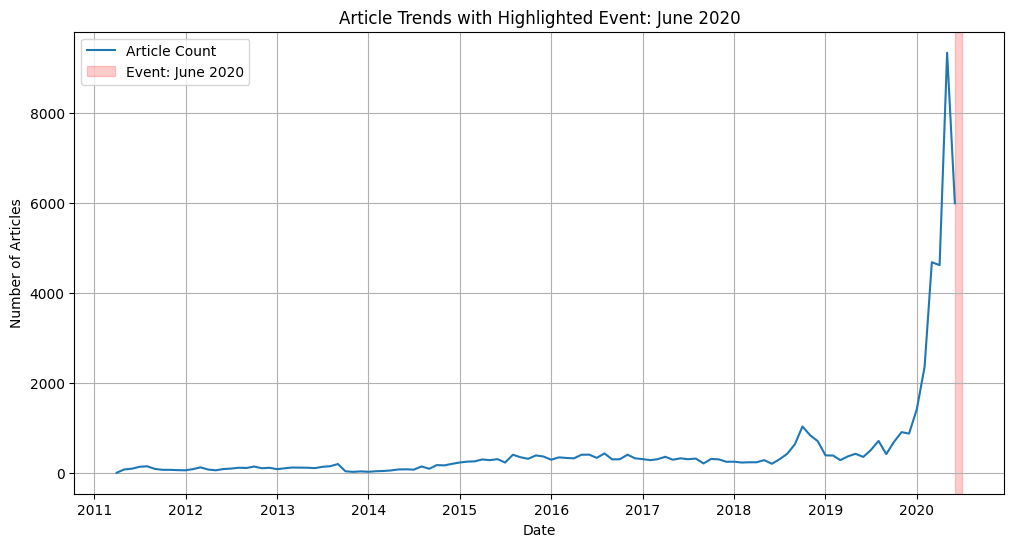

In [16]:
# Highlight a specific event period (example: June 2020)
plt.figure(figsize=(12, 6))
plt.plot(monthly_counts['date'], monthly_counts['article_count'], label='Article Count')
plt.axvspan('2020-06-01', '2020-06-30', color='red', alpha=0.2, label='Event: June 2020')
plt.title('Article Trends with Highlighted Event: June 2020')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ==========================
# Topic Modeling (LDA)
# ==========================

# Text preprocessing
news['clean_headline'] = news['headline'].str.lower().str.replace(r'[^a-z\s]', '', regex=True)

vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
X = vectorizer.fit_transform(news['clean_headline'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

In [31]:
# Get feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Display top words in each topic
def print_topics(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Topic {topic_idx + 1}: {' '.join(top_words)}")

print_topics(lda, feature_names)


Topic 1: stocks week benzingas biggest new etfs movers yesterday watch hit
Topic 2: vs est eps reports earnings sales sees estimate scheduled fy
Topic 3: announces initiates bank coverage industry analyst dividend hold new america
Topic 4: pt trading upgrades buy raises target price maintains downgrades shares
Topic 5: market shares stocks update session moving says premarket higher markets



Top Words per Topic:

Topic 1:
target, price, buy, morgan, downgrades, coverage, initiates, announces, pt, shares

Topic 2:
market, stocks, higher, oil, etfs, companies, trading, shares, scheduled, earnings

Topic 3:
week, raises, moving, session, sales, reports, eps, stocks, est, vs

Topic 4:
news, option, alert, biggest, new, movers, yesterday, shares, update, market

Topic 5:
market, new, update, says, beats, reports, announces, sales, eps, estimate


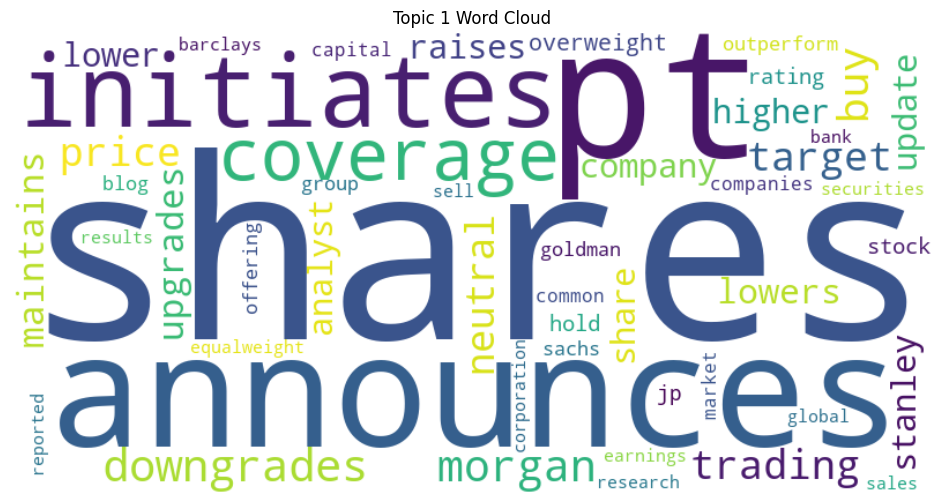

In [18]:
# Display topics
print("\nTop Words per Topic:")
for idx, topic in enumerate(lda.components_):
    print(f"\nTopic {idx + 1}:")
    print(", ".join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]))

# Wordcloud for topic 1
topic_0_words = lda.components_[0]
word_freq = {vectorizer.get_feature_names_out()[i]: topic_0_words[i] for i in topic_0_words.argsort()[-50:]}

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Topic 1 Word Cloud')
plt.show()